In [1]:
from Neuron_analysis_tool.load import Analyzer, long_pulse_protocol
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


In [2]:

def Rin_func(seg):
    imp = h.Impedance(seg.x, sec=seg.sec)
    imp.loc(seg.x, sec=seg.sec)
    imp.compute(0, 1)
    return imp.input(seg.x, sec=seg.sec)


In [3]:

dir_path = os.path.abspath('')
morph_path=os.path.join(dir_path,'data/morph.ASC')

analyser = Analyzer(type='ASC', morph_path=morph_path)
cell = analyser.cell
apic = list(cell.apical)
basal = list(cell.basal)

parts_dict = {'soma':[], 'basal':[], 'apical':[], 'axon':[], 'else':[]}
colors_dict = {'soma':'k', 'basal':'r', 'apical':'b', 'axon':'green', 'else':'cyan'}
for sec in cell.all:
    for seg in sec:
        if sec in cell.soma:
            parts_dict['soma'].append(seg)
        elif sec in basal:
            parts_dict['basal'].append(seg)
        elif sec in apic:
            parts_dict['apical'].append(seg)
        elif sec in cell.axon:
            parts_dict['axon'].append(seg)
        else:
            parts_dict['else'].append(seg)

analyser.change_parts_dict(parts_dict=parts_dict, colors_dict=colors_dict)


17089 lines read

/ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/data/morph.ASC problems


Main branch starting at line 305 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 3635 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 12344.54it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}>,
        <AxesSubplot:title={'center':'short pulse attanuation'}>],
       dtype=object))

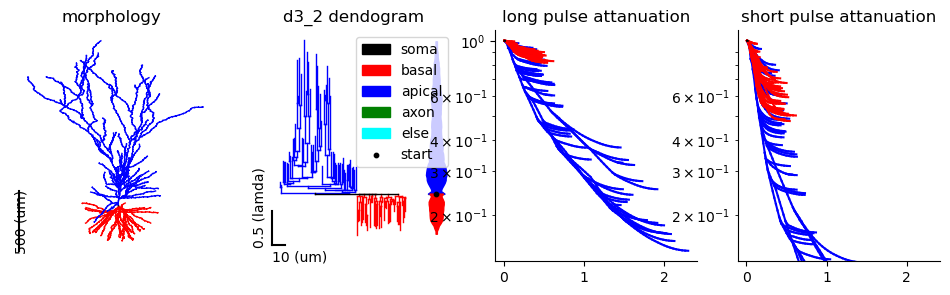

In [11]:
analyser.create_card(theta=-75)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 13142.34it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}>,
        <AxesSubplot:title={'center':'short pulse attanuation'}>],
       dtype=object))

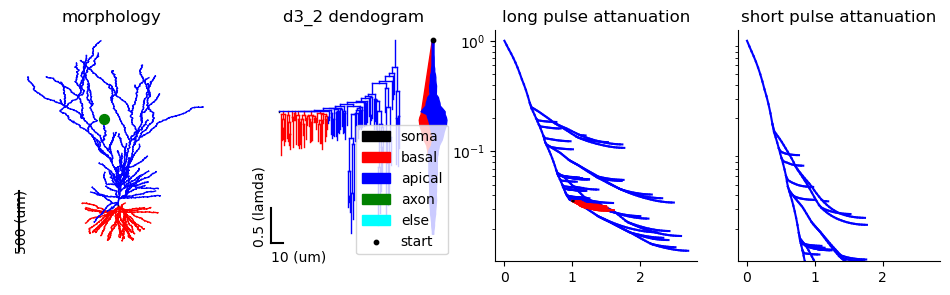

In [12]:
analyser.create_card(initial_seg=list(cell.apic[101])[-1], theta=-75)

optimizing lines: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 8793.58it/s]


(<AxesSubplot:title={'center':'Rin with color code'}>,
 <matplotlib.colorbar.ColorbarBase at 0x7f5982fb0b80>)

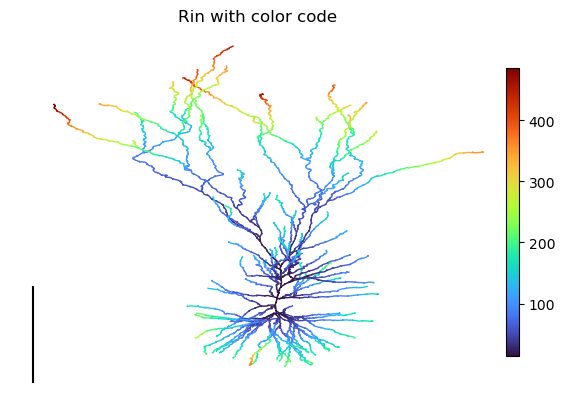

In [5]:
plt.title('Rin with color code')
analyser.plot_morph_with_value_func(func = Rin_func, run_time=1000, theta=-75, scale=500)
